In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
sys.path.append("..")
import minimise
import energy_utils as energy
# Enable or disable Tensor Float 32 Execution
tf.config.experimental.enable_tensor_float_32_execution(False)
import matplotlib.pyplot as plt
import scipy.constants as const


2026-01-26 09:23:42.111872: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-26 09:23:42.146790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
modelc1_path = "../../models/c1_dipole_Apr30.keras" 
modeln1_path = "../../models/n1_dipole_Apr30.keras"
modelc1_path = "../../models/c1_dipole_Mar9.keras" 
modeln1_path = "../../models/n1_dipole_Mar9.keras"



model_c1 = keras.models.load_model(modelc1_path)
model_n1 = keras.models.load_model(modeln1_path)

2026-01-26 09:23:49.079129: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2026-01-26 09:23:49.079188: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: bubbletea
2026-01-26 09:23:49.079201: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: bubbletea
2026-01-26 09:23:49.079404: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 570.211.1
2026-01-26 09:23:49.079447: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 570.195.3
2026-01-26 09:23:49.079459: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 570.195.3 does not match DSO version 570.211.1 -- cannot find working devices in this configuration
/home/btb32/.conda

In [3]:
temp = 500 
L = 20
dx = 0.02  # spatial step in Angstroms
zbins = np.arange(0, L+dx, dx)

kappa_inv = 4.5  # inverse screening length

dielectric = 1.0
mu_correction = 0.0
Vext = np.zeros_like(zbins)
mu = -6.5 # dipole
muloc = - Vext + mu 
initial_guess = np.zeros_like(zbins)*0.0 + dx

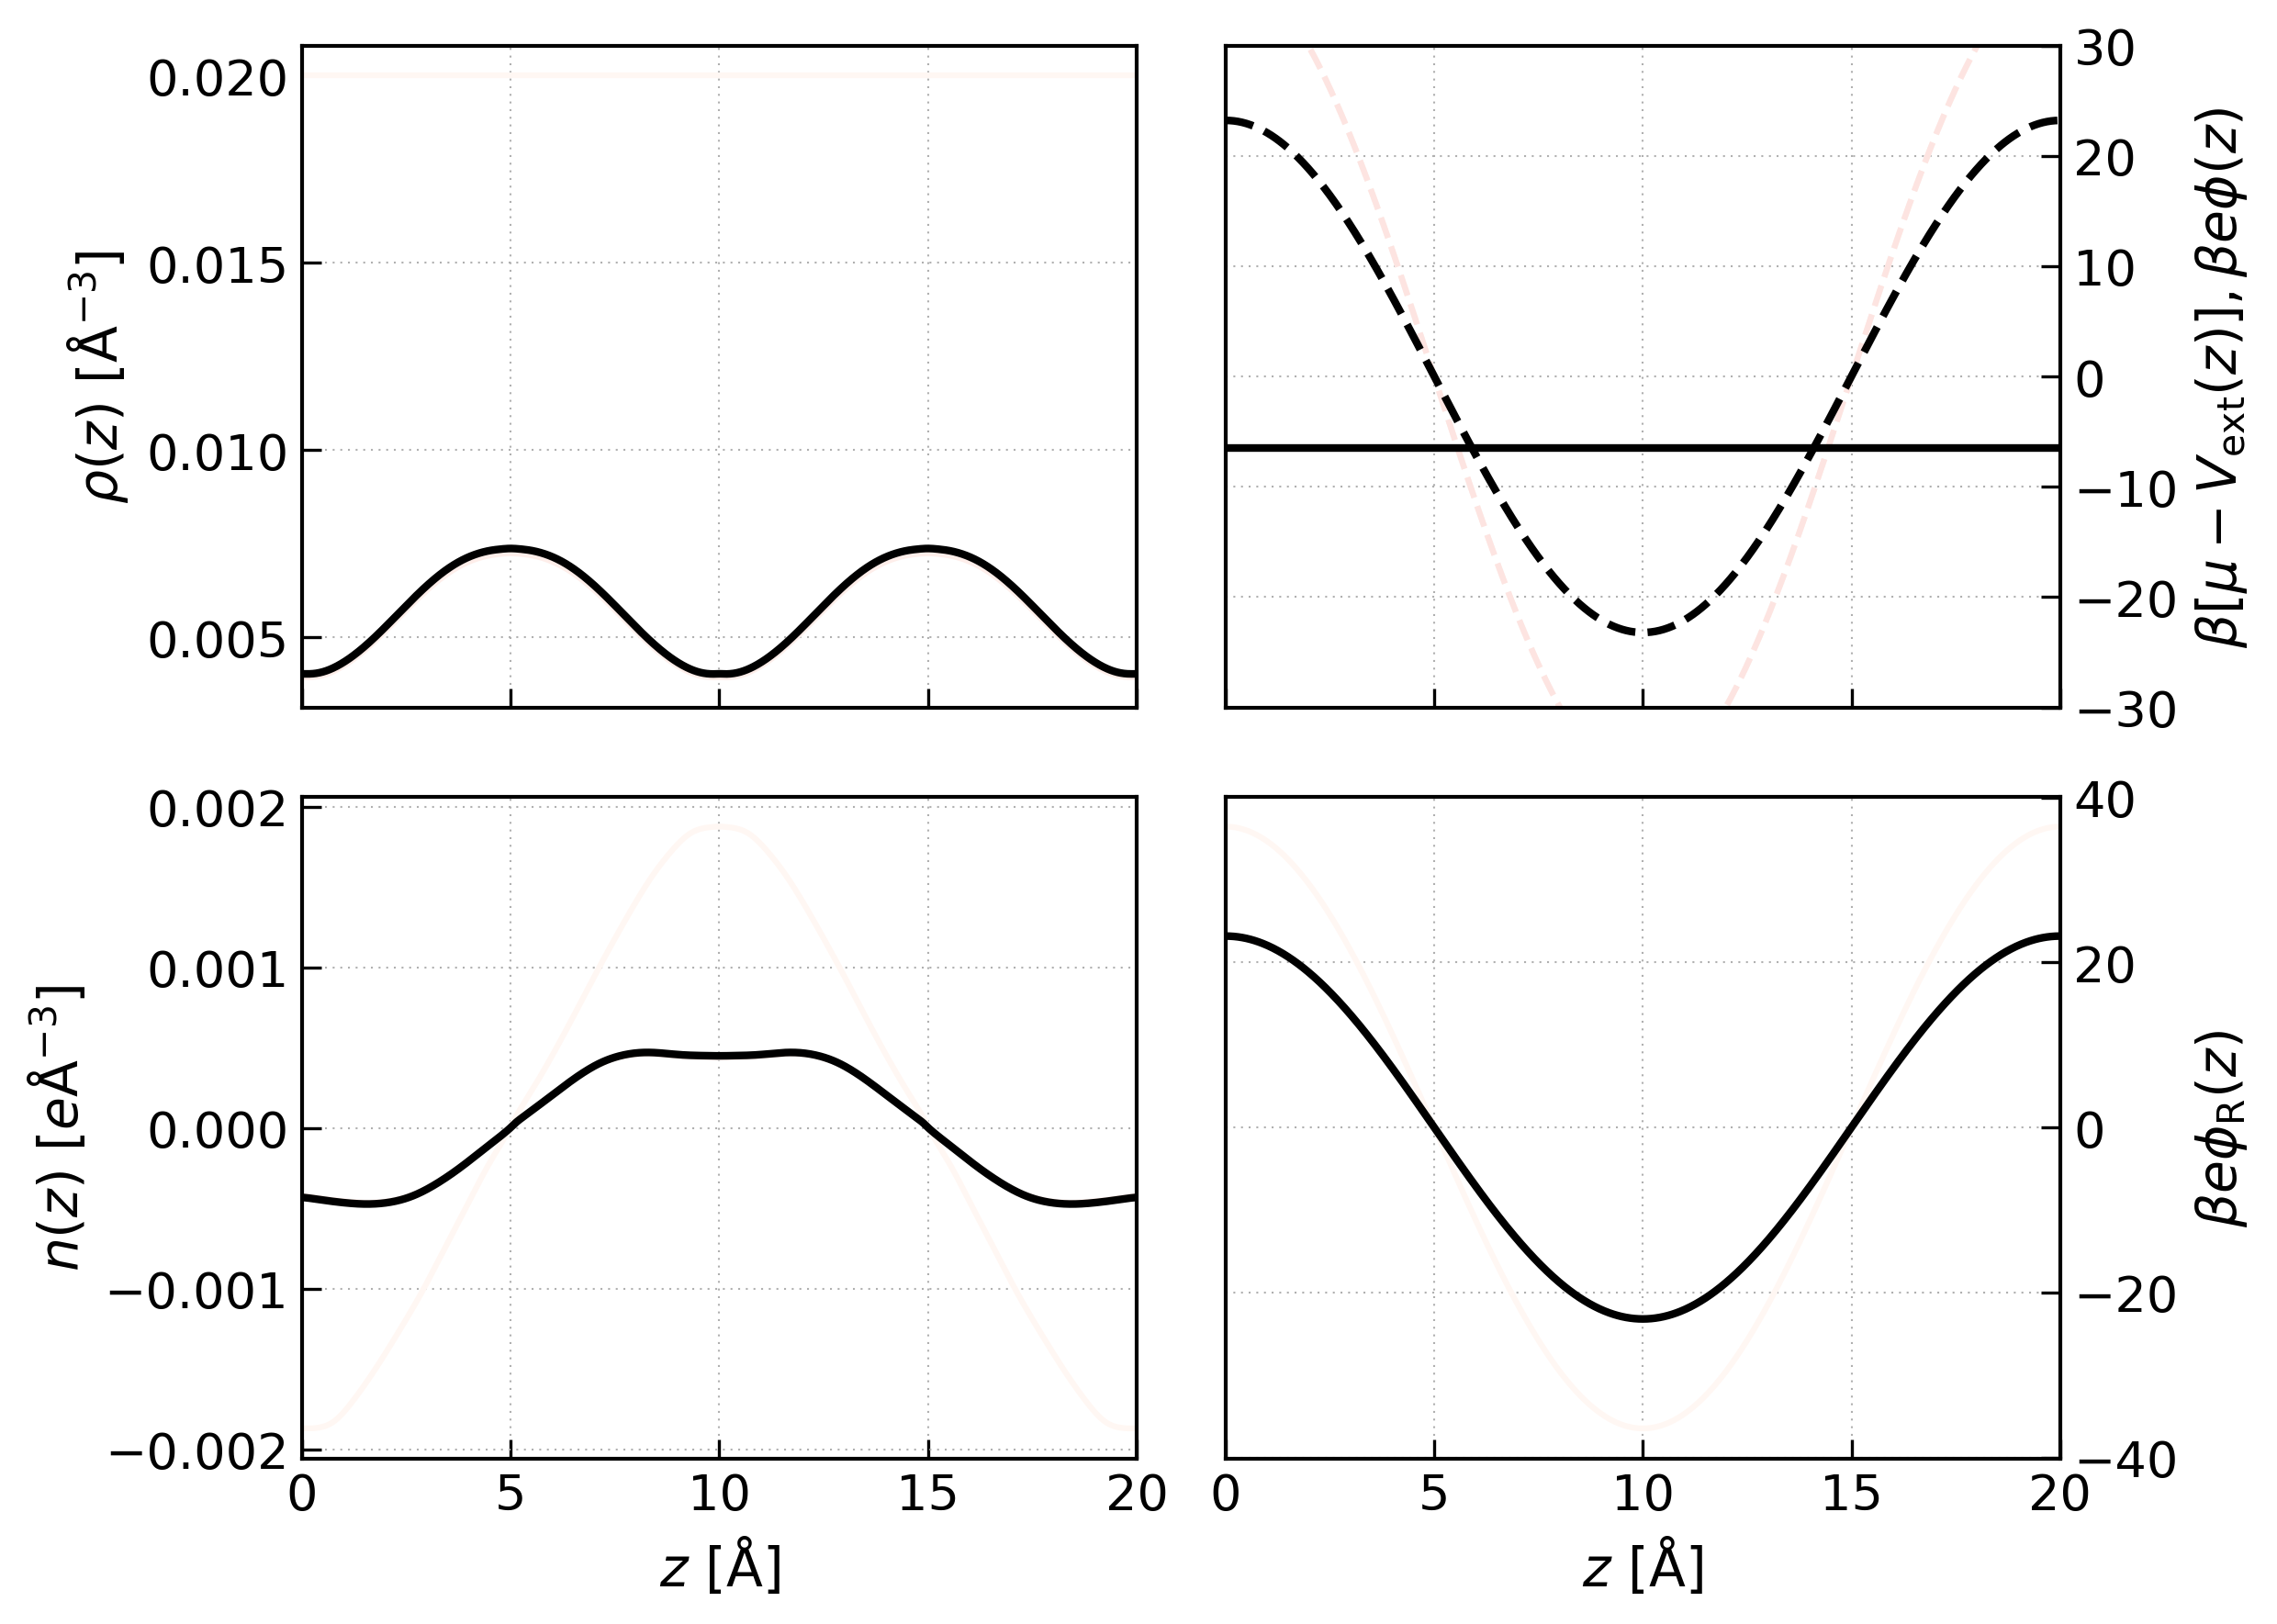

In [4]:


k = 1
 
amp = 0.5
    
A  = 2*np.pi*k/L        
E_field = -np.sin(A*zbins)*amp
elec_grad = np.zeros_like(zbins) + E_field / (const.Boltzmann * temp / const.elementary_charge)
Phi_field = np.cos(A*zbins)*amp/A 
elec = np.zeros_like(zbins) + Phi_field / (const.Boltzmann * temp / const.elementary_charge)
  
zs, rho_DFT, n_DFT, elecR_DFT = minimise.minimise_LR(
        model_c1, model_n1, zbins, muloc,  elec, temp,
        kappa_inv, dielectric, mu_correction, dx=dx,
        initial_guess=initial_guess, tolerance=1.8e-4, tolerance_restr = 1e-4,
        maxiter=10000,
        plot=True, plot_every=300, print_every=300,
        symmetric=True, chargesymmetry=True)

rho_mean = np.mean(rho_DFT)
betaFid, betaFexrho, betaFexphi, betamuterm = energy.get_free_energy(temp, rho_DFT, elec, mu, dx, model_c1, model_n1)

angtrom3_to_m3 = 1e30
pa_to_atm = 101325


omega_per_area = (const.k * temp * (betaFid + betaFexrho + betamuterm) / (dx*(len(rho_DFT)-1))) * angtrom3_to_m3/pa_to_atm


